In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from nilearn.plotting import plot_design_matrix, plot_stat_map, view_img
from nilearn.reporting import get_clusters_table
from nilearn import datasets
import glob
import os
import numpy as np
import pandas as pd

/Users/zeynepenkavi/.pyenv/versions/3.8.3/envs/py-dvl-fmri/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
def get_filt_tval_img(reg, reg_rt = "0", mnum = "1", mname = 'overall-mean', tstat="1", threshold=0.95):
    
    level3_path = '/Users/zeynepenkavi/Downloads/GTavares_2017_arbitration/bids_nifti_wface/derivatives/nilearn/glm/level3/'
    model_path = 'model'+mnum+'_reg-rt'+reg_rt
    img_path = os.path.join(level3_path, model_path, mname, reg+'_'+model_path)
    
    pos_pval_fn = 'rand_tfce_corrp_tstat%s_pos_%s_%s_model%s_reg-rt%s.nii.gz'%(tstat, mname, reg, mnum, reg_rt)
    neg_pval_fn = 'rand_tfce_corrp_tstat%s_neg_%s_%s_model%s_reg-rt%s.nii.gz'%(tstat, mname, reg, mnum, reg_rt)
    tval_fn = 'rand_tfce_tstat%s_pos_%s_%s_model%s_reg-rt%s.nii.gz'%(tstat, mname, reg, mnum, reg_rt)
    
    pos_pval_img = os.path.join(img_path, pos_pval_fn)
    neg_pval_img = os.path.join(img_path, neg_pval_fn)
    tval_img = os.path.join(img_path, tval_fn)
    
    pos_pval_img = nib.load(pos_pval_img)
    neg_pval_img = nib.load(neg_pval_img)
    tval_img = nib.load(tval_img)
    
    tval_data = tval_img.get_fdata()
    pos_pval_data = pos_pval_img.get_fdata()
    neg_pval_data = neg_pval_img.get_fdata()
    
    filt_tval_data = np.where(pos_pval_data > threshold, tval_data, np.where(neg_pval_data > threshold, tval_data, 0))
    filt_tval_img = nib.Nifti1Image(filt_tval_data.astype(np.float64), tval_img.affine)
    
    return filt_tval_img

def plot_filt_tval_img(reg, reg_rt = "0", mnum = "1", mname = 'overall-mean', tstat="1", threshold=0.95, interactive=False, cut_coords = None, display_mode = 'ortho', draw_cross=False, title=None):
    filt_tval_img = get_filt_tval_img(reg=reg, reg_rt = reg_rt, mnum = mnum, mname = mname, tstat=tstat, threshold=threshold)
    if title is None:
        title='%s_model%s_reg-rt%s'%(reg, mnum, reg_rt)
    
    if(len(np.unique(filt_tval_img.get_fdata())) == 1):
        print('Nothing survives correction for %s, model = %s, tstat = %s, reg_rt = %s at threshold p < %s'%(reg, mnum, tstat, reg_rt, str(round(1-threshold, 2))))
    elif interactive:
        view = view_img(filt_tval_img, 
             draw_cross=draw_cross,
             title=title, cut_coords = cut_coords)
        
        return view
    else:
        print('Plotting tvalues filtered for corrected p values < %s'%str(round(1-threshold, 2)))
        plot_stat_map(filt_tval_img, 
             draw_cross=draw_cross,
             title=title, cut_coords = cut_coords, display_mode = display_mode)

        
def get_filt_diff_tval_img(reg,  mnum1, mnum2, reg_rt1="0", reg_rt2="0", reg2=None, mname="overall-mean", tstat="1", threshold=0.95):
    
    if reg2 is None:
        reg2 = reg
    
    img1 = get_filt_tval_img(reg=reg, reg_rt = reg_rt1, mnum = mnum1, mname = mname, tstat=tstat, threshold=threshold)
    img2 = get_filt_tval_img(reg=reg2, reg_rt = reg_rt2, mnum = mnum2, mname = mname, tstat=tstat, threshold=threshold)
    
    img1_data = img1.get_fdata()
    img2_data = img2.get_fdata()
    filt_diff_tval_data = img1_data - img2_data
    filt_diff_tval_img = nib.Nifti1Image(filt_diff_tval_data.astype(np.float64), img1.affine)
    
    return filt_diff_tval_img
        
def plot_filt_diff_tval_img(reg, mnum1, mnum2, reg_rt1="0", reg_rt2="0",reg2 = None, mname = 'overall-mean', tstat="1", threshold=0.95, disp_threshold = 2, interactive=False, cut_coords = None, display_mode = 'ortho', draw_cross=False, title=None):
    filt_diff_tval_img = get_filt_diff_tval_img(reg=reg, reg_rt1 = reg_rt1, reg_rt2 = reg_rt2, mnum1 = mnum1, mnum2 = mnum2, reg2 = reg2, mname = mname, tstat=tstat, threshold=threshold)
    if title is None:
        title='%s model%s_reg-rt%s - model%s_reg-rt%s '%(reg, mnum1, reg_rt1, mnum2, reg_rt2)
    
    if(len(np.unique(filt_diff_tval_img.get_fdata())) == 1):
        print('Nothing survives correction for the difference image %s, model = %s, tstat = %s at threshold p < %s'%(reg, mnum, tstat, str(round(1-threshold, 2))))
    
    elif interactive:
        view = view_img(filt_diff_tval_img, 
             draw_cross=draw_cross,
             title=title, cut_coords = cut_coords, threshold = disp_threshold)
        
        return view
    else:
        print('Plotting tvalues filtered for corrected p values < %s'%str(round(1-threshold, 2)))
        plot_stat_map(filt_diff_tval_img, 
             draw_cross=draw_cross,
             title=title, cut_coords = cut_coords, display_mode = display_mode, threshold = disp_threshold)

        
def get_mean_cor_df(reg_rt = "0", mnum = "1"):
    
    level3_path = '/Users/zeynepenkavi/Downloads/GTavares_2017_arbitration/bids_nifti_wface/derivatives/nilearn/glm/level3/'
    model_path = 'model'+mnum+'_reg-rt'+reg_rt
    df_path = os.path.join(level3_path, model_path, model_path+'_mean_desmat_cor.csv')
    
    mean_cor_df = pd.read_csv(df_path)
    
    return(mean_cor_df)

# Regressor types

- ev = event; amplitude = 1  
- par = parametric; amplitude = demeaned    
- st = stick (0 duration); amplitude = 1 
- rt = reaction time; amplitude = demeaned RT

Citing Grinband et al. (2008) people agree that reaction times must be taken into account but model them in different ways. Schonberg, Poldrack et al. papers use overall response time for event and parametric regressor as well as a parametric RT regressor. Many in the rest of the decision making literature use boxcars with RT durations (e.g. Dunsmoor et al. (2011), Chang et al. (2011), Chang and Sanfey (2013), Shuck et al. (2016)). 

Since it is common to use boxcars with RT duration and I don't know others who model RT the way Poldrack et al. do I will present those results below.

# Model 1: fractalProb_ev + stim_ev + choiceShift_st + reward_ev

Correlation between regressors averaged across subjects and runs

In [3]:
get_mean_cor_df(reg_rt = "0", mnum = "1")

,Unnamed: 0,choiceShift_st,fractalProb_ev,reward_ev,stim_ev
0,choiceShift_st,1.000000,0.470769,0.745801,0.811198
1,fractalProb_ev,0.470769,1.000000,-0.100907,0.594187
2,reward_ev,0.745801,-0.100907,1.000000,0.447179
3,stim_ev,0.811198,0.594187,0.447179,1.000000


Plotting tvalues filtered for corrected p values < 0.05


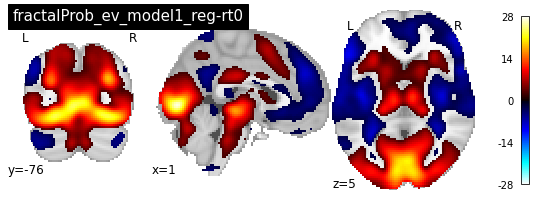

In [4]:
reg = 'fractalProb_ev'
mnum = '1'
plot_filt_tval_img(reg, mnum = mnum)

Plotting tvalues filtered for corrected p values < 0.05


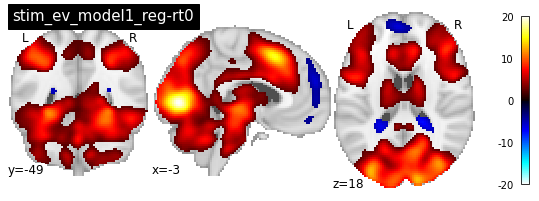

In [5]:
reg = 'stim_ev'
mnum = '1'
plot_filt_tval_img(reg, mnum = mnum)

Check for left motor cortex activity. Cross is the precentral gyrus peak reported in Hare et al.

Plotting tvalues filtered for corrected p values < 0.05


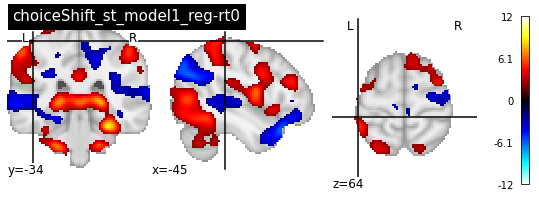

In [6]:
reg = 'choiceShift_st'
mnum = '1'
cut_coords = (-45, -34, 64)
draw_cross = True

plot_filt_tval_img(reg, mnum = mnum, cut_coords = cut_coords, draw_cross = draw_cross)

Motor cortex activity is a little ventral than expected but more consistent for choiceShift regressor. It is, however, not lateralized to the left.

Plotting tvalues filtered for corrected p values < 0.05


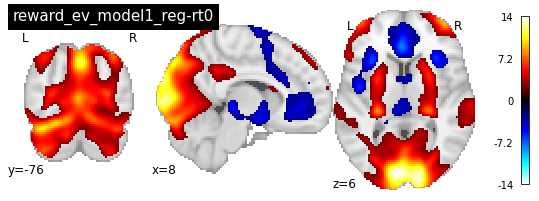

In [7]:
reg = 'reward_ev'
mnum = '1'
plot_filt_tval_img(reg, mnum = mnum)

# Model 1a: fractalProb_ev + stim_ev + choiceShiftLeft_st + choiceShiftRight_st + reward_ev

In [ ]:
plot_filt_diff_tval_img(reg="choiceShiftLeft_st", reg_rt1="0", reg_rt2="0", mnum1="1a", mnum2="1", reg2 = "choiceShift_st", cut_coords = cut_coords)
plot_filt_diff_tval_img(reg="choiceShiftRight_st", reg_rt1="0", reg_rt2="0", mnum1="1a", mnum2="1", reg2 = "choiceShift_st", cut_coords = cut_coords)
plot_filt_diff_tval_img(reg="choiceShiftRight_st", reg_rt1="0", reg_rt2="0", mnum1="1a", mnum2="1a", reg2 = "choiceShiftLeft_st", cut_coords = cut_coords)


# Model 2: Model 1 + fractalProb_par

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "2")

In [ ]:
regs = ['fractalProb_ev', 'stim_ev', 'choiceShift_st', 'reward_ev']
mnum = '2'

for reg in regs:
#     plot_filt_diff_tval_img(reg, mnum1="1", mnum2=mnum)
    print('No interesting change from Model 1 for %s in Model %s'%(reg, mnum))

In [ ]:
reg = 'fractalProb_par'
mnum = '2'
plot_filt_tval_img(reg, mnum = mnum)

# Model 3: Model 2 + valDiff_par

In [8]:
get_mean_cor_df(reg_rt = "0", mnum = "3")

,Unnamed: 0,choiceShift_st,fractalProb_ev,fractalProb_par,reward_ev,stim_ev,valDiff_par
0,choiceShift_st,1.000000,0.470769,0.004342,0.745801,0.811198,0.000397
1,fractalProb_ev,0.470769,1.000000,-0.000011,-0.100907,0.594187,0.000875
2,fractalProb_par,0.004342,-0.000011,1.000000,0.008211,-0.024602,-0.029480
3,reward_ev,0.745801,-0.100907,0.008211,1.000000,0.447179,0.001079
4,stim_ev,0.811198,0.594187,-0.024602,0.447179,1.000000,-0.002334
5,valDiff_par,0.000397,0.000875,-0.029480,0.001079,-0.002334,1.000000


In [ ]:
regs = ['fractalProb_ev', 'stim_ev', 'choiceShift_st', 'reward_ev']
mnum = '3'

for reg in regs:
#     plot_filt_diff_tval_img(reg, mnum1="1", mnum2=mnum)
    print('No interesting change from Model 1 for %s in Model %s'%(reg, mnum))
    
# plot_filt_diff_tval_img('fractalProb_par', mnum1="2", mnum2=mnum)
print('No interesting change from Model 2 for %s in Model %s'%('fractalProb_par', mnum))

Plotting tvalues filtered for corrected p values < 0.05


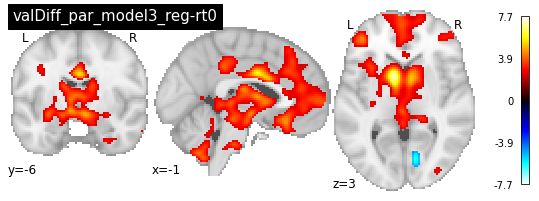

In [16]:
reg = 'valDiff_par'
mnum = '3'
plot_filt_tval_img(reg, mnum = mnum)

# Model 4: Model 2 + valChosen + valUnchosen

In [15]:
get_mean_cor_df(reg_rt = "0", mnum = "4")

,Unnamed: 0,choiceShift_st,fractalProb_ev,fractalProb_par,reward_ev,stim_ev,valChosen_par,valUnchosen_par
0,choiceShift_st,1.000000,0.470769,0.004342,0.745801,0.811198,-0.023165,0.017313
1,fractalProb_ev,0.470769,1.000000,-0.000011,-0.100907,0.594187,-0.012483,0.010231
2,fractalProb_par,0.004342,-0.000011,1.000000,0.008211,-0.024602,-0.139386,-0.009099
3,reward_ev,0.745801,-0.100907,0.008211,1.000000,0.447179,-0.006565,0.005388
4,stim_ev,0.811198,0.594187,-0.024602,0.447179,1.000000,-0.090410,0.062400
5,valChosen_par,-0.023165,-0.012483,-0.139386,-0.006565,-0.090410,1.000000,0.209166
6,valUnchosen_par,0.017313,0.010231,-0.009099,0.005388,0.062400,0.209166,1.000000


In [ ]:
regs = ['fractalProb_ev', 'choiceShift_st', 'reward_ev']
mnum = '4'

for reg in regs:
#     plot_filt_diff_tval_img(reg, mnum1="1", mnum2=mnum)
    print('No interesting change from Model 1 for %s in Model %s'%(reg, mnum))
    
# plot_filt_diff_tval_img('fractalProb_par', mnum1="2", mnum2=mnum)
# print('No interesting change from Model 2 for %s in Model %s'%('fractalProb_par', mnum))

In [ ]:
regs = ['stim_ev', 'fractalProb_par']
mnum = '4'

plot_filt_tval_img('stim_ev', mnum = "1")
plot_filt_tval_img('stim_ev', mnum = mnum)

Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for valUnchosen_par, model = 4, tstat = 1, reg_rt = 0 at threshold p < 0.05


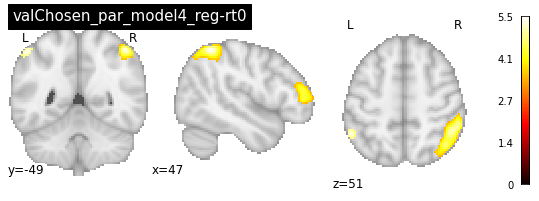

In [17]:
regs = ['valChosen_par', 'valUnchosen_par']
mnum = '4'

for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

# Model 5: Model 2 + valDiffLottery + valDiffFractal

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "5")

In [ ]:
regs = ['fractalProb_ev', 'stim_ev', 'choiceShift_st', 'reward_ev']
mnum = '5'

for reg in regs:
#     plot_filt_diff_tval_img(reg, mnum1="1", mnum2=mnum)
    print('No interesting change from Model 1 for %s in Model %s'%(reg, mnum))
    
# plot_filt_diff_tval_img('fractalProb_par', mnum1="2", mnum2=mnum)
print('No interesting change from Model 2 for %s in Model %s'%('fractalProb_par', mnum))

Plotting tvalues filtered for corrected p values < 0.05


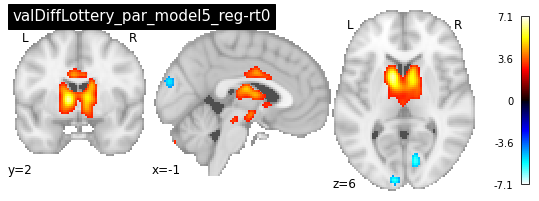

In [10]:
reg = 'valDiffLottery_par'
mnum = '5'
plot_filt_tval_img(reg, mnum = mnum)


In [11]:
reg = 'valDiffFractal_par'
mnum = '5'
plot_filt_tval_img(reg ,mnum = mnum)

Nothing survives correction for valDiffFractal_par, model = 5, tstat = 1, reg_rt = 0 at threshold p < 0.05


# Model 5a: Model 2 + valDiffLotteryWeighted + valDiffFractalWeighted

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "5a")

In [ ]:
regs = ['fractalProb_ev', 'stim_ev', 'choiceShift_st', 'reward_ev']
mnum = '5a'

for reg in regs:
#     plot_filt_diff_tval_img(reg, mnum1="1", mnum2=mnum)
    print('No interesting change from Model 1 for %s in Model %s'%(reg, mnum))
    
# plot_filt_diff_tval_img('fractalProb_par', mnum1="2", mnum2=mnum)
print('No interesting change from Model 2 for %s in Model %s'%('fractalProb_par', mnum))

Plotting tvalues filtered for corrected p values < 0.05


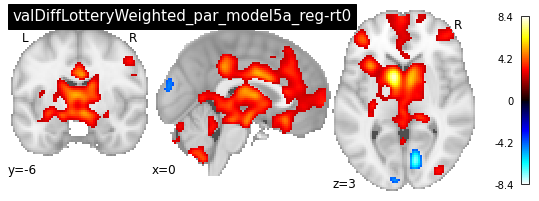

In [18]:
reg = 'valDiffLotteryWeighted_par'
mnum = '5a'
plot_filt_tval_img(reg, mnum = mnum)


In [19]:
reg = 'valDiffFractalWeighted_par'
mnum = '5a'
plot_filt_tval_img(reg ,mnum = mnum)


Nothing survives correction for valDiffFractalWeighted_par, model = 5a, tstat = 1, reg_rt = 0 at threshold p < 0.05


# Model 5b: Model 2 + valDiffLotteryLowPFrac_par + valDiffLotteryMedPFrac_par + valDiffLotteryHighPFrac_par + valDiffFractalLowPFrac_par + valDiffFractalMedPFrac_par + valDiffFractalHighPFrac_par

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "5b")

In [ ]:
regs = ['fractalProb_ev', 'stim_ev', 'choiceShift_st', 'reward_ev']
mnum = '5b'

for reg in regs:
#     plot_filt_diff_tval_img(reg, mnum1="1", mnum2=mnum)
    print('No interesting change from Model 1 for %s in Model %s'%(reg, mnum))
    
# plot_filt_diff_tval_img('fractalProb_par', mnum1="2", mnum2=mnum)
print('No interesting change from Model 2 for %s in Model %s'%('fractalProb_par', mnum))

Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for valDiffLotteryMedPFrac_par, model = 5b, tstat = 1, reg_rt = 0 at threshold p < 0.05
Nothing survives correction for valDiffLotteryHighPFrac_par, model = 5b, tstat = 1, reg_rt = 0 at threshold p < 0.05
Nothing survives correction for valDiffFractalLowPFrac_par, model = 5b, tstat = 1, reg_rt = 0 at threshold p < 0.05
Nothing survives correction for valDiffFractalMedPFrac_par, model = 5b, tstat = 1, reg_rt = 0 at threshold p < 0.05
Nothing survives correction for valDiffFractalHighPFrac_par, model = 5b, tstat = 1, reg_rt = 0 at threshold p < 0.05


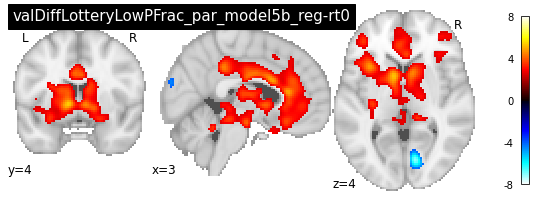

In [12]:
regs = ['valDiffLotteryLowPFrac_par', 'valDiffLotteryMedPFrac_par', 'valDiffLotteryHighPFrac_par', 'valDiffFractalLowPFrac_par', 'valDiffFractalMedPFrac_par', 'valDiffFractalHighPFrac_par']

mnum = '5b'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

# Model 6: Model 2 + valChosenLottery + valUnchosenLottery + valChosenFractal + valUnchosenFractal

In [20]:
get_mean_cor_df(reg_rt = "0", mnum = "6")

,Unnamed: 0,choiceShift_st,fractalProb_ev,fractalProb_par,reward_ev,stim_ev,valChosenFractal_par,valChosenLottery_par,valUnchosenFractal_par,valUnchosenLottery_par
0,choiceShift_st,1.000000,0.470769,0.004342,0.745801,0.811198,-0.020103,-0.005748,0.010069,0.005163
1,fractalProb_ev,0.470769,1.000000,-0.000011,-0.100907,0.594187,-0.011851,-0.001981,0.007220,0.001666
2,fractalProb_par,0.004342,-0.000011,1.000000,0.008211,-0.024602,0.093670,-0.104914,-0.096686,0.091940
3,reward_ev,0.745801,-0.100907,0.008211,1.000000,0.447179,-0.008294,-0.000097,0.004349,-0.000290
4,stim_ev,0.811198,0.594187,-0.024602,0.447179,1.000000,-0.057551,-0.036551,0.023430,0.034909
5,valChosenFractal_par,-0.020103,-0.011851,0.093670,-0.008294,-0.057551,1.000000,-0.095536,-0.120330,0.046834
6,valChosenLottery_par,-0.005748,-0.001981,-0.104914,-0.000097,-0.036551,-0.095536,1.000000,0.109697,0.099568
7,valUnchosenFractal_par,0.010069,0.007220,-0.096686,0.004349,0.023430,-0.120330,0.109697,1.000000,-0.065471
8,valUnchosenLottery_par,0.005163,0.001666,0.091940,-0.000290,0.034909,0.046834,0.099568,-0.065471,1.000000


In [ ]:
regs = ['fractalProb_ev', 'choiceShift_st', 'reward_ev']
mnum = '6'

for reg in regs:
#     plot_filt_diff_tval_img(reg, mnum1="1", mnum2=mnum)
    print('No interesting change from Model 1 for %s in Model %s'%(reg, mnum))
    
# plot_filt_diff_tval_img('fractalProb_par', mnum1="2", mnum2=mnum)
print('No interesting change from Model 2 for %s in Model %s'%('fractalProb_par', mnum))

In [ ]:
reg = 'stim_ev'
mnum = '6'
plot_filt_tval_img(reg, mnum = mnum)

Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for valUnchosenLottery_par, model = 6, tstat = 1, reg_rt = 0 at threshold p < 0.05
Nothing survives correction for valChosenFractal_par, model = 6, tstat = 1, reg_rt = 0 at threshold p < 0.05
Nothing survives correction for valUnchosenFractal_par, model = 6, tstat = 1, reg_rt = 0 at threshold p < 0.05


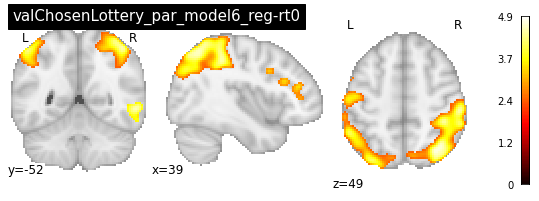

In [21]:
regs = ['valChosenLottery_par', 'valUnchosenLottery_par', 'valChosenFractal_par', 'valUnchosenFractal_par']
mnum = '6'

for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

# Model 6a: Model 2 + valChosenLotteryWeighted + valUnchosenLotteryWeighted + valChosenFractalWeighted + valUnchosenFractalWeighted

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "6a")

In [ ]:
regs = ['fractalProb_ev', 'stim_ev', 'choiceShift_st', 'reward_ev']
mnum = '6a'

for reg in regs:
    plot_filt_diff_tval_img(reg, mnum1="1", mnum2=mnum)
#     print('No interesting change from Model 1 for %s in Model %s'%(reg, mnum))
    
plot_filt_diff_tval_img('fractalProb_par', mnum1="2", mnum2=mnum)
# print('No interesting change from Model 2 for %s in Model %s'%('fractalProb_par', mnum))

Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for valChosenFractalWeighted_par, model = 6a, tstat = 1, reg_rt = 0 at threshold p < 0.05
Nothing survives correction for valUnchosenFractalWeighted_par, model = 6a, tstat = 1, reg_rt = 0 at threshold p < 0.05


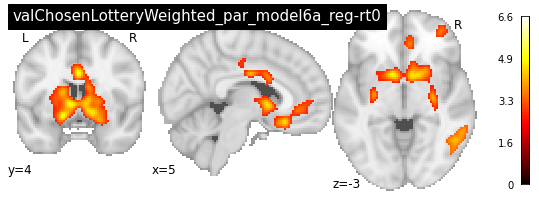

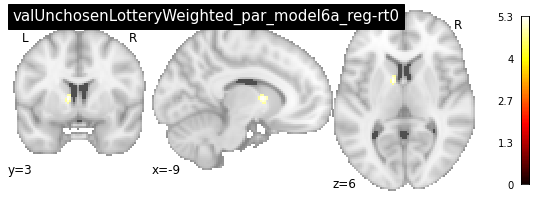

In [13]:
regs = ['valChosenLotteryWeighted_par', 'valUnchosenLotteryWeighted_par', 'valChosenFractalWeighted_par', 'valUnchosenFractalWeighted_par']
mnum = '6a'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

Is this meaningful or a by-product of sparse regressors?

# Model 7: Model 5 + reward_par + rewardLeftFractal_par + rewardRightFractal_par + rpeLeftFractal_par + rpeRightFractal_par + ppe_par

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "7")

In [ ]:
regs = ['fractalProb_ev', 'stim_ev', 'choiceShift_st', 'reward_ev']
mnum = '7'

for reg in regs:
#     plot_filt_diff_tval_img(reg, mnum1="1", mnum2=mnum)
    print('No interesting change from Model 1 for %s in Model %s'%(reg, mnum))
    
# plot_filt_diff_tval_img('fractalProb_par', mnum1="2", mnum2=mnum)
print('No interesting change from Model 2 for %s in Model %s'%('fractalProb_par', mnum))

Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for valDiffFractal_par, model = 7, tstat = 1, reg_rt = 0 at threshold p < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for rewardLeftFractal_par, model = 7, tstat = 1, reg_rt = 0 at threshold p < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for rpeLeftFractal_par, model = 7, tstat = 1, reg_rt = 0 at threshold p < 0.05
Nothing survives correction for rpeRightFractal_par, model = 7, tstat = 1, reg_rt = 0 at threshold p < 0.05
Plotting tvalues filtered for corrected p values < 0.05


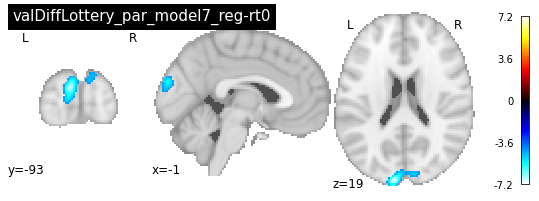

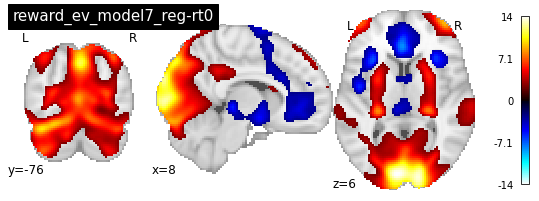

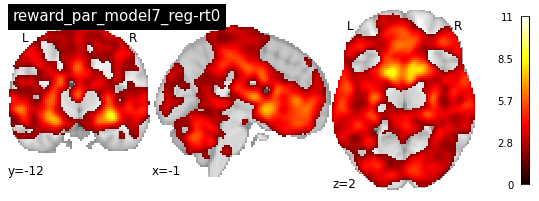

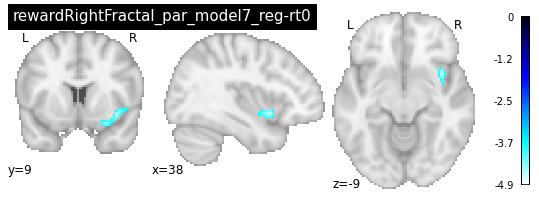

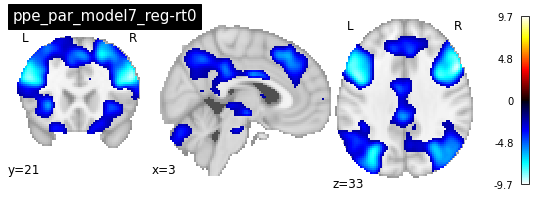

In [14]:
regs = ['valDiffLottery_par', 'valDiffFractal_par', 'reward_ev', 'reward_par', 'rewardLeftFractal_par', 'rewardRightFractal_par','rpeLeftFractal_par', 'rpeRightFractal_par', 'ppe_par']
mnum = '7'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

Plotting tvalues filtered for corrected p values < 0.01


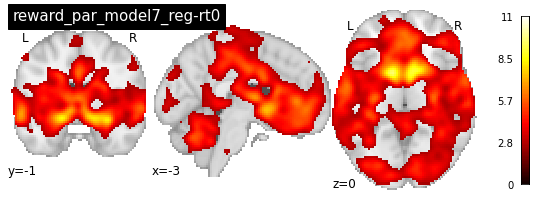

In [24]:
plot_filt_tval_img("reward_par", mnum = "7", threshold=.99)